## Logistic Regression

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from pca import PCA
import argparse
import network
import os, random, sys
from data import traffic_sign, generate_k_fold_set
from model.logistic import LogisticRegression
#from logistic_regression import LogisticRegression
train_loss_record = []
train_accuracy_record = []
holdout_loss_record = []
holdout_accuracy_record = []
test_accuracy_record = []
n_components = 40


In [21]:
load_data = traffic_sign()
train_data, train_label, valid_data, valid_label, test_data, test_label = generate_k_fold_set(load_data)
#class set up
pca = PCA(train_data, n_components)

projected, mean_image, sqrt_eigen_values, eigen_vectors  = pca.PCA_Emmet()


NameError: name 'LogisticRegression' is not defined

In [27]:
#Q5 - (a) - added in logistic.py
def select_binarydata(dataset, class_a,class_b):
    Data, labels = dataset
    print(np.shape(Data),np.shape(labels))
    #only save class a, and class b.
    idx_class_a = np.where(labels == class_a)
    idx_class_b = np.where(labels == class_b)
    Data_class_a = Data[idx_class_a]
    Data_class_b = Data[idx_class_b]

    Data_ = np.concatenate([Data_class_a,Data_class_b])
    label_ = np.concatenate([labels[idx_class_a],labels[idx_class_b]])
    return   Data_ ,label_
    # Image : (cnt, 32x32 byte = 1024) in one img data , 1 byte in one image data


#Q5 - (b) - Evaluate the model on Speed limit 100km/h vs 120km/h using the unaligned dataset

(34799, 1024) (34799,)


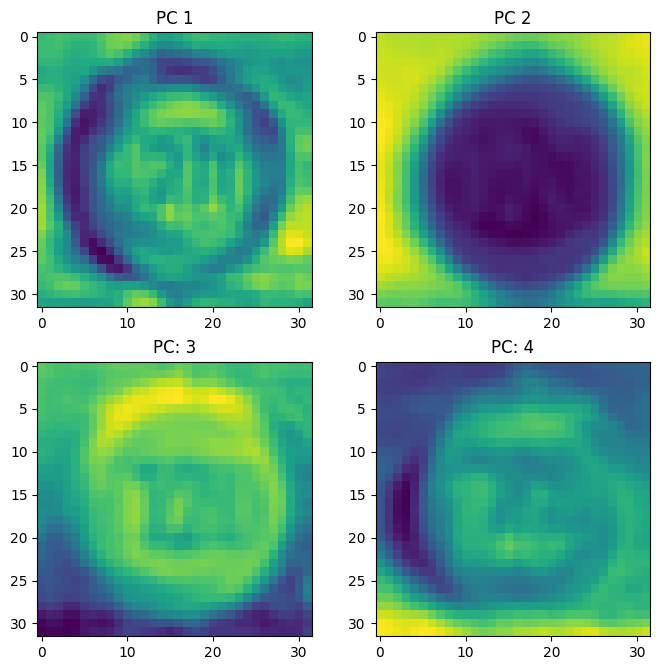

In [28]:
#unlined dataset - pca looks pretty bad.
#change data only for 100km/h and 120km/h
load_data = traffic_sign(False)
load_data_binary = select_binarydata(load_data,7,8)
#data splits
train_data, train_label, valid_data, valid_label, test_data, test_label = generate_k_fold_set(load_data_binary)
pca = PCA(train_data, n_components)
projected, mean_image, sqrt_eigen_values, eigen_vectors  = pca.PCA_Emmet()
pca.plot_PC()


In [36]:
#train 50 epochs as opposed to 300
logistic = LogisticRegression(n_components)
w = np.random.rand(n_components + 1, 1)
Alpha = 0.5

for epoch in range(300):
    #logistic model 
    train_y = simple_logistic_model(w, train_data)
    #loss check
    train_loss = logistic.loss(train_y, train_label)
    #gradient check
    dw = simple_logistic_model_gradient_descent(model_output, train_data, true_train)
    train_accuracy = logistic.check_accuracy(train_y, train_label)
    train_loss_record.append(train_loss)
    train_accuracy_record.append(train_accuracy)
    #update the weight
    w = w + Alpha * dw
    #process for validation sets
    holdout_y = logistic.forward(valid_data)
    holdout_loss = logistic.loss(holdout_y, valid_label)
    holdout_accuracy = logistic.check_accuracy(holdout_y, valid_label)
    holdout_loss_record.append(holdout_loss)
    holdout_accuracy_record.append(holdout_accuracy)
    
print(f'test accuracy: {train_accuracy_record}')
plot('loss', train_loss_record, holdout_loss)
plot('accuracy', train_accuracy_record, holdout_accuracy_record)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1025 is different from 41)

In [ ]:
loss_train = []
loss_valid = []
min_loss_valid = 100000
best_w = w
# Train the model  
for epoch in range(300):
    #Logistic model
    model_output = simple_logistic_model(w, train_data)
    # Cross entropy loss
    loss_train.append(simple_logistic_model_loss(model_output, train_data, true_train))
    # Get the gradient
    dw = simple_logistic_model_gradient_descent\
        (model_output, train_data, true_train)
    #update the weight
    w = w + learning_rate * dw
    model_valid_output = simple_logistic_model(w, valid_data)
    loss_valid.append(simple_logistic_model_loss(model_valid_output, valid_data, true_valid))
    if(loss_valid[-1] < min_loss_valid):
        best_w = w
        min_loss_valid = loss_valid[-1]

# Check accuracy on test set
model_test_output = simple_logistic_model(best_w, test_data)
pred_test = np.array([0 if i < 0.5 else 1 for i in model_test_output])           
accu_test = np.sum(pred_test == true_test) / len(pred_test)
print('Accuracy on test set is {:.4f}'.format(accu_test))

##Q5 - (c) - Evaluate the model on Curve Left vs Right using the aligned dataset

In [ ]:
#Q5 - (d) - Evaluate the model on Speed limit 100km/h vs 120km/h using the aligned dataset